In [1]:
import time
from coffea import hist, nanoevents, util
import coffea.processor as processor
import awkward as ak
import numpy as np
import glob as glob
import re
import itertools
# import vector as vec
from coffea.nanoevents.methods import vector, candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema
from coffea.lumi_tools import LumiMask
# for applying JECs
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
from coffea.jetmet_tools import JetResolution, JetResolutionScaleFactor
# from jmeCorrections import JetMetCorrections
import json


import coffea.processor as processor
from coffea import hist
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import nanoaod

# NanoAODSchema.warn_missing_crossrefs = False

import pickle
# np.errstate(invalid='ignore', divide='ignore')

In [2]:
fnameMC = "./Mphi-1995_Mchi-1000_2018_1.root"
fname="Mphi-1995_Mchi-1000_2018"
#eventsMC = NanoEventsFactory.from_root(fnameMC).events()

In [3]:
#eventsMC.fields

In [11]:
class Newttag(processor.ProcessorABC):
    def __init__(self):
        self._fields = """
        AK15PFPuppi_Jet_pt
        AK15PFPuppi_Jet_phi
        AK15PFPuppi_Jet_eta
        AK15PFPuppi_Jet_particleNetAK15_TvsQCD
        GenPart_eta
        GenPart_phi
        GenPart_pt
        GenPart_pdgId
        GenPart_status
        GenPart_statusFlags
        nGenPart
        FatJet_phi
        FatJet_pt
        FatJet_eta
        FatJet_mass
        nFatJet
        """.split()
        
        self._accumulator = processor.dict_accumulator({
            "ak15jetpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("ak15jetpt", "AK15 Jet pT", 100, 0, 2000),
            ),
            "qWmatchedJet": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Cat('tag', 'Hadronic Top matching AK15jet'),
                hist.Bin('qWmatchedJet','TvsQCD',100,0,1)
            ),
            "tvsqcd": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("tvsqcd","TvsQCD",100,0,1),
            ),
            "drfjtop": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("drfjtop","dR(ak15jet, top)",100,0,10),
            ),
            "toppt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("toppt","Top pT",100,0,1000),
            ),
            "metpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("metpt", "MET", 100, 0, 2000),
            )
        })
    @property
    def accumulator(self):
        return self._accumulator
    @property
    def fields(self):
        return self._fields
    
    def process(self, events):
        
        dataset = events.metadata['dataset']
        selection = processor.PackedSelection()
        output = self.accumulator.identity()
        
        #print(events.AK15PFPuppi.fields)

        met = events.MET
        gen = events.GenPart
        top = events.GenPart[abs(events.GenPart.pdgId) == 6]
        jet = events.FatJet
        
        cut_ak15pt = events.AK15PFPuppi['Jet_pt']>250

        ak15jet = events.AK15PFPuppi[cut_ak15pt]
        ak15jet['pt'] = events.AK15PFPuppi['Jet_pt'][cut_ak15pt]
        ak15jet['phi'] = events.AK15PFPuppi['Jet_phi'][cut_ak15pt]
        ak15jet['eta'] = events.AK15PFPuppi['Jet_eta'][cut_ak15pt]
        ak15jet['mass'] = events.AK15PFPuppi['Jet_mass'][cut_ak15pt]
        ak15jet['TvsQCD'] = events.AK15PFPuppi['Jet_particleNetAK15_TvsQCD'][cut_ak15pt]
        ak15jet["T"] = ak.zip({"pt": ak15jet.Jet_pt, "phi": ak15jet.Jet_phi},
                       with_name="PolarTwoVector",
                       behavior=vector.behavior)
        ak15jet['p4'] = ak.zip({
            "pt": ak15jet.Jet_pt[cut_ak15pt],
            "eta": ak15jet.Jet_eta[cut_ak15pt],
            "phi": ak15jet.Jet_phi[cut_ak15pt],
            "mass": ak15jet.Jet_mass[cut_ak15pt]},
            with_name="PtEtaPhiMCollection",
        )
        #print('fields: ', ak15jet.fields)
        
        #print('ak.type(top) ',ak.type(top))
        #print('ak15jet.TvsQCD ', len(ak15jet.TvsQCD))
        #print('cut_ak15pt ', cut_ak15pt)
        print('gen: ', gen)
        
        qFromW = gen[
            (abs(gen.pdgId) < 5) & # 1: d, 2: u, 3: s, 4: c
            gen.hasFlags(['fromHardProcess', 'isFirstCopy']) &
            (abs(gen.distinctParent.pdgId) == 24)  # 24: W
        ]
        print('qFromW: ', qFromW)
        qFromWFromTop = qFromW[qFromW.distinctParent.distinctParent.pdgId == 6]
        print('qFromWFromTop:', qFromWFromTop) #ak.flatten(qFromWFromTop))
        #qWmatch = ak.any(ak.num(ak.flatten(qFromWFromTop), axis=1)>0, axis=-1) # Number of q from W from Top decay
        print('ak.num(qFromWFromTop): ', ak.num(qFromWFromTop))
        qWmatch = ak.all(ak.num(qFromWFromTop) > 0, axis=-1)
        print('qWmatch: ', qWmatch)
        print('qWmatchfj: ', ak15jet.TvsQCD[qWmatch]) # qWmatch&passdr
        #print('qWmatch:', qWmatch)

        print('children:', ak.any(top.distinctChildren.pdgId == 24))
        #topDecayW = top[abs(top.distinctChildren.pdgId) == 24]
        #topDecayq = top[abs(top.distinctChildren.distinctChildren.pdgId) < 5]
        
        LJ_top = ak.cartesian({"ak15jet":ak15jet.p4, "gentop": top})
        #LJ_top = ak.cartesian({"ak15jet":ak15jet.p4, "gentop": qWmatchT})
        #LJ_top = ak.cartesian({"jet":jet, "gentop": top})
        #print('LJ_top: ', LJ_top)
        ak15jets, gentops = ak.unzip(LJ_top)
        #print('ak15jets: ', ak15jets)
        #print('gentops: ', gentops)
        #print('LJ_top.jet type:', type(LJ_top.ak15jet))
        #print('LJ_top.gentop type:', type(LJ_top.gentop))
        #DeltaR_LJ_top = abs(jets.delta_r(gentops))
        DeltaR_LJ_top = abs(LJ_top.ak15jet.delta_r(LJ_top.gentop))
        print('DeltaR: ', DeltaR_LJ_top)

        #dRfjtoT = top.metric_table(ak15jet)
        #dRfjtoT = ak15jet.metric_table(top)

        passdr = ak.all(DeltaR_LJ_top < 0.8, axis=-1)
        #print('num mindRfjT is 0', ak.num(mindRfjtoT) < 1)
        print('passdr:', passdr)

        print('ak15jet.TvsQCD: ', ak15jet.TvsQCD)
        #print('len(ak15jet.TvsQCD)' , len(ak15jet.TvsQCD))
        print('ak15jet.TvsQCD[passdr]:', ak15jet.TvsQCD[passdr])
        #print('ak15jet.TvsQCD[passdr] ', ak.flatten(ak15jet.TvsQCD[passdr]))
        #print('7.0', dRfjtoT[dRfjtoT<1.5].tolist())
        #print('7.2', type(dRfjtoT))
        #print('7.2', ak15jet.TvsQCD[dRfjtoT<1.5])
        

        #print(ak15jet.pt)
        
        #passdr = dRfjtoT < 1.5
        #passttag = tvsqcd > 0.65 #ak15jet['Jet_particleNetAK15_TvsQCD'] > 0.65 #self._TvsQCDwp['2018']

        output["ak15jetpt"].fill(
            dataset=dataset,
            ak15jetpt= ak.flatten(ak15jet.pt) #ak15jet['Jet_pt']
        )
        output["qWmatchedJet"].fill(
            dataset=dataset,
            tag='pass',
            qWmatchedJet=ak.flatten(ak15jet.TvsQCD[passdr&qWmatch])
        )
        output["qWmatchedJet"].fill(
            dataset=dataset,
            tag='fail',
            qWmatchedJet=ak.flatten(ak15jet.TvsQCD[~passdr&qWmatch])
        )
        output["metpt"].fill(
            dataset=dataset,
            metpt=met.pt
        )
        output["toppt"].fill(
            dataset=dataset,
            toppt=ak.flatten(top.pt)
        )
        output["tvsqcd"].fill(
            dataset=dataset,
            tvsqcd=ak.flatten(ak15jet.TvsQCD)
        )
        output["drfjtop"].fill(
            dataset=dataset,
            drfjtop= ak.flatten(DeltaR_LJ_top) #ak.flatten(ak.flatten(dRfjtoT))
        )

        return output
    
    def postprocess(self, accumulator):
        return accumulator
    


In [12]:
fnameMC = "./Mphi-1995_Mchi-1000_2018_1.root"
fnameMCs = [
    "root://cmseos.fnal.gov//store/group/lpcmetx/Monotop/CustomNanoProdV9/2018/Mphi-1995_Mchi-1000_2018/Mphi-1995_Mchi-1000_2018_1.root",
    "root://cmseos.fnal.gov//store/group/lpcmetx/Monotop/CustomNanoProdV9/2018/Mphi-1995_Mchi-1000_2018/Mphi-1995_Mchi-1000_2018_2.root",
    "root://cmseos.fnal.gov//store/group/lpcmetx/Monotop/CustomNanoProdV9/2018/Mphi-1995_Mchi-1000_2018/Mphi-1995_Mchi-1000_2018_3.root"
]
fnameMCs = [
    "root://cmseos.fnal.gov//store/group/lpcmetx/Monotop/CustomNanoProdV9/2018/Mphi-1995_Mchi-1000_2018/Mphi-1995_Mchi-1000_2018_1.root",
    "root://cmseos.fnal.gov//store/group/lpcmetx/Monotop/CustomNanoProdV9/2018/Mphi-1995_Mchi-1000_2018/Mphi-1995_Mchi-1000_2018_2.root",
    "root://cmseos.fnal.gov//store/group/lpcmetx/Monotop/CustomNanoProdV9/2018/Mphi-1995_Mchi-1000_2018/Mphi-1995_Mchi-1000_2018_3.root"
]
onefiles = [
    "./Mphi-1995_Mchi-1000_2018_1.root",
    "root://xrootd-cms.infn.it//store/user/empfeffe/customNano/DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8/KIT_CustomNanoV9_MC_2018/211220_132108/0000/MC_2018_NanoAODv9_189.root",
]
samples = {
    "signal": fnameMCs
    #"signal": [fnameMC]
    #"dy": onefiles
}

In [13]:
result = processor.run_uproot_job(
    samples,
    "Events",
    Newttag(),
    #processor.iterative_executor,
    processor.futures_executor,
    #{"schema": NanoAODSchema},
    executor_args={'schema': NanoAODSchema,'workers': 8},
)


Processing:   0%|          | 0/5 [00:00<?, ?chunk/s]

gen:  [[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]
gen:  [[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]
gen:  [[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]
qFromW:  [[None, None, None, None, None, None, None, ... None, None, None, None, None, None]]
qFromWFromTop: [[None, None, None, None, None, None, None, ... None, None, None, None, None, None]]
ak.num(qFromWFromTop):  [16, 7, 11, 16, 11, 6, 7, 5, 11, 10, 7, ... 15, 33, 30, 11, 8, 8, 5, 10, 4, 7, 11]
qWmatch:  True
qWmatchfj:  []
qFromW:  [[None, None, GenParticle, GenParticle, None, ... None, None, None, None, None]]
qFromWFromTop: [[None, None, GenParticle, GenParticle, None, ... None, None, None, None, None]]
ak.num(qFromWFromTop):  [6, 6, 7, 16, 5, 6, 10, 8, 7, 8, 3, 18, ... 4, 7, 24, 8, 4, 6, 19, 34, 11, 6, 8, 8]
qWmatch:  True
gen:  [[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticl

In [14]:
print(result)
print(result['qWmatchedJet'])

{'ak15jetpt': <Hist (dataset,ak15jetpt) instance at 0x7fc3b80a8358>, 'qWmatchedJet': <Hist (dataset,tag,qWmatchedJet) instance at 0x7fc4026edc18>, 'tvsqcd': <Hist (dataset,tvsqcd) instance at 0x7fc4026edcc0>, 'drfjtop': <Hist (dataset,drfjtop) instance at 0x7fc4026ed2b0>, 'toppt': <Hist (dataset,toppt) instance at 0x7fc4026ed320>, 'metpt': <Hist (dataset,metpt) instance at 0x7fc4026edbe0>}
<Hist (dataset,tag,qWmatchedJet) instance at 0x7fc4026edc18>


ak15jetpt
qWmatchedJet
tvsqcd
drfjtop
toppt
metpt


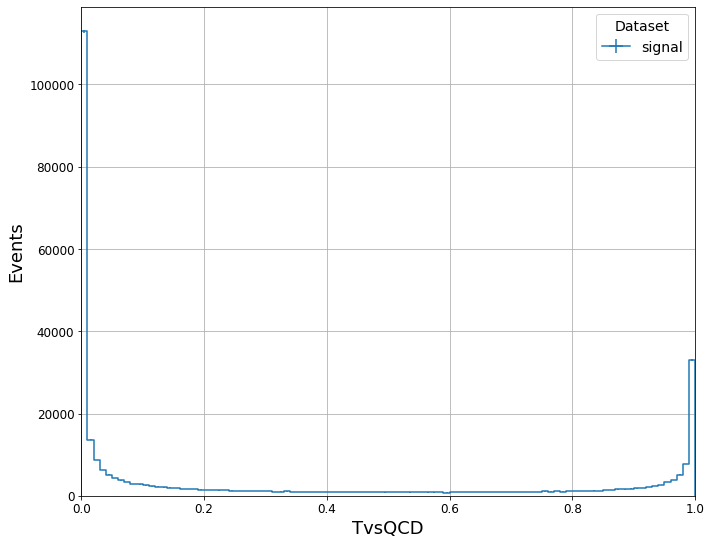

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

scaled = {}
for name, h in result.items():
    if isinstance(h, hist.Hist):
        scaled[name] = h.copy()
        print(name)

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(11,9)})
plt.grid(True)
#ax = hist.plot1d(scaled['qWmatchedJet'].integrate('tag','pass'), overlay='dataset')
x = hist.plot1d(scaled['tvsqcd'], overlay='dataset')
#plt.xlim(0,10)
#plt.ylim(0.000001,1)
#plt.yscale('log')

<Hist (qWmatchedJet) instance at 0x7fc4026252b0>
<Hist (qWmatchedJet) instance at 0x7fc4026255c0>
sum_bins_arr:  [319494. 206588. 192916. 184232. 177930. 172790. 168454. 164679. 161343.
 158427. 155667. 153144. 150844. 148591. 146564. 144579. 142726. 141019.
 139390. 137774. 136244. 134831. 133504. 132187. 130861. 129588. 128343.
 127102. 125963. 124859. 123725. 122645. 121641. 120620. 119572. 118598.
 117610. 116659. 115730. 114811. 113878. 112941. 112048. 111141. 110260.
 109325. 108468. 107611. 106718. 105863. 105035. 104186. 103343. 102471.
 101668. 100781.  99939.  99115.  98296.  97461.  96665.  95784.  94926.
  94003.  93161.  92291.  91452.  90518.  89655.  88785.  87835.  86917.
  85979.  85001.  84056.  83084.  82014.  80995.  79875.  78855.  77744.
  76560.  75339.  74092.  72825.  71594.  70178.  68793.  67246.  65676.
  63921.  62142.  60232.  58124.  55733.  53051.  49710.  45862.  40712.
  32980.]
tot[fname]:  319494.0


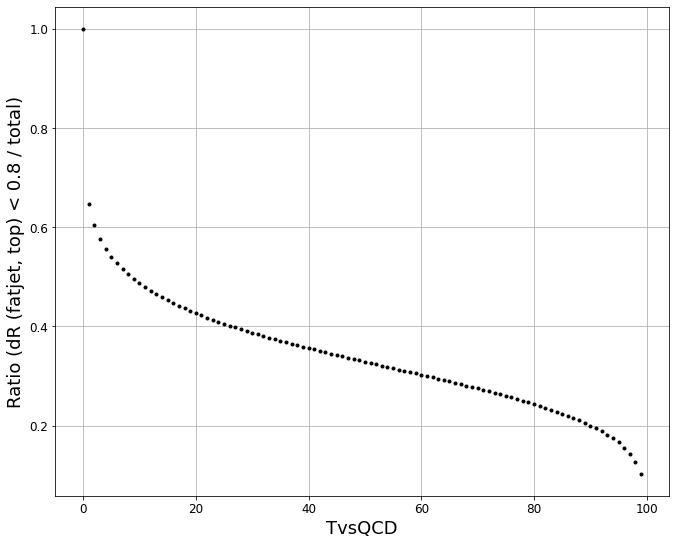

In [20]:
# nume/deno
from coffea.hist import plot

denominator = scaled['qWmatchedJet'].integrate('dataset').integrate('tag')
numerator   = scaled['qWmatchedJet'].integrate('dataset').integrate('tag','pass')

print(denominator)
print(numerator)

sum_bins = list()
for n in range(len(denominator.values()[()])):
    sum_bins.append(denominator.values()[()][n:].sum())
    
sum_bins_arr = np.array(sum_bins)
print('sum_bins_arr: ',sum_bins_arr)

numerator_sum = hist.Hist(
    'Events',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('nume_sum', 'TvsQCD', 100, sum_bins_arr.min(),sum_bins_arr.max())
)
numerator_sum.fill(dataset = fname, nume_sum=sum_bins_arr)

tot = {}
tot[fname] = scaled['qWmatchedJet'].integrate('dataset').integrate('tag').sum('qWmatchedJet').values()[()]
print('tot[fname]: ', tot[fname])

hhh = sum_bins_arr/tot[fname]
ggg = np.arange(0,1,0.01)

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(11,9)})
plt.grid(True)

plt.ylabel('Ratio (dR (fatjet, top) < 0.8 / total)')
plt.xlabel('TvsQCD')

#plt.plot(ggg,hhh,'k.')
plt.plot(hhh,'k.')

#plt.xticks(np.arange(0,1,0.1))
#plt.yticks(np.arange(0,1,0.1))


In [ ]:
numerator.label = 'Ratio'
ax = plot.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': 'o'},
    unc='num',
    label='dR (ak15jet, gentop) < 1.5'
)

In [30]:
##### FOR DEBUG #####
class Newttag(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "ak15jetpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("ak15jetpt", "AK15 Jet pT", 100, 0, 2000),
            ),
            "qWmatchedJet": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Cat('tag', 'Hadronic Top matching AK15jet'),
                hist.Bin('qWmatchedJet','TvsQCD',100,0,1)
            ),
            "tvsqcd": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("tvsqcd","TvsQCD",100,0,1),
            ),
            "drfjtop": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("drfjtop","dR(ak15jet, top)",100,0,10),
            ),
            "toppt": hist.Hist(
                "Events",.integrate('dataset')
                hist.Cat("dataset", "Dataset"),
                hist.Bin("toppt","Top pT",100,0,1000),
            ),
            "metpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("metpt", "MET", 100, 0, 2000),
            )
        })
    @property
    def accumulator(self):
        return self._accumulator
    def process(self, events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        #print(events.AK15PFPuppi.fields)

        met=events.MET
        gen = events.GenPart
        top = events.GenPart[abs(events.GenPart.pdgId) == 6]
        
        cut_ak15pt = events.AK15PFPuppi['Jet_pt']>250
        #ak15jet = {}
        ak15jet = events.AK15PFPuppi[cut_ak15pt]
        ak15jet['pt'] = events.AK15PFPuppi['Jet_pt'][cut_ak15pt]
        ak15jet['phi'] = events.AK15PFPuppi['Jet_phi'][cut_ak15pt]
        ak15jet['eta'] = events.AK15PFPuppi['Jet_eta'][cut_ak15pt]
        ak15jet['mass'] = events.AK15PFPuppi['Jet_mass'][cut_ak15pt]
        ak15jet['TvsQCD'] = events.AK15PFPuppi['Jet_particleNetAK15_TvsQCD'][cut_ak15pt]
        
        #print('ak.type(top) ',ak.type(top))
        #print('ak.type(ak15jet) ',ak.type(ak15jet))
        print('ak15jet.TvsQCD ', len(ak15jet.TvsQCD))
        print('cut_ak15pt ',cut_ak15pt)
        
        qFromW = gen[
            (abs(gen.pdgId) < 5) & # 1: d, 2: u, 3: s, 4: c
            gen.hasFlags(['fromHardProcess', 'isFirstCopy']) &
            (abs(gen.distinctParent.pdgId) == 24)  # 24: W
        ]
        qFromWFromTop = qFromW[qFromW.distinctParent.distinctParent.pdgId == 6]
        qWmatch = ak.num(qFromWFromTop)>0 # Number of q from W from Top decay
        #print('qWmatch', len(qWmatch))
        #print('qFromWFromTop', ak.num(qFromWFromTop))
        #topDecayq = top[abs(top.distinctChildren.distinctChildren.pdgId) < 5]

        dRfjtoT = top.metric_table(ak15jet)
        print('dRfjtoT', dRfjtoT)
        mindRfjtoT = ak.min(dRfjtoT, axis=2)
        print('mindRfjtoT', mindRfjtoT)
        fj_iso_from_T = ak15jet[mindRfjtoT > 0.4]
        print('fj_iso_from_T', fj_iso_from_T)
        
        dRTtofj = top.metric_table(ak15jet)
        print('dRTtofj ', dRTtofj)
        mindRTtofj = ak.min(dRTtofj, axis=2)
        print('mindRTtofj', mindRTtofj)
        T_iso_from_fj = top[mindRTtofj > 0.4]
        #fj_iso_from_T = ak15jet[mindRTtofj > 0.4]
        print('T_iso_from_fj', T_iso_from_fj)
        
#        print('dRfjtoT', dRfjtoT)
#        print('dRTtofj ', dRTtofj)
#        print('mindRfjtoT', mindRfjtoT)
#        print('mindRTtofj', mindRTtofj)
#        print('fj_iso_from_T', fj_iso_from_T)
#        print('T_iso_from_fj', T_iso_from_fj)
        
        print('fj_iso_from_T.TvsQCD', fj_iso_from_T.TvsQCD)
               
        

        #print(ak15jet.pt)
        
        #passdr = dRfjtoT < 1.5
        #passttag = tvsqcd > 0.65 #ak15jet['Jet_particleNetAK15_TvsQCD'] > 0.65 #self._TvsQCDwp['2018']

        output["ak15jetpt"].fill(
            dataset=dataset,
            ak15jetpt= ak.flatten(ak15jet.pt) #ak15jet['Jet_pt']
        )
        output["qWmatchedJet"].fill(
            dataset=dataset,
            tag='pass',
            qWmatchedJet=ak.flatten(ak15jet.TvsQCD[passdr])
        )
        output["qWmatchedJet"].fill(
            dataset=dataset,
            tag='fail',
            qWmatchedJet=ak.flatten(ak15jet.TvsQCD[~passdr])
        )
        output["metpt"].fill(
            dataset=dataset,
            metpt=met.pt
        )
        output["toppt"].fill(
            dataset=dataset,
            toppt=ak.flatten(top.pt)
        )
        output["tvsqcd"].fill(
            dataset=dataset,
            tvsqcd=ak.flatten(ak15jet.TvsQCD)
        )
        output["drfjtop"].fill(
            dataset=dataset,
            drfjtop= ak.flatten(mindRfjtoT) #ak.flatten(ak.flatten(dRfjtoT))
        )

        return output
    
    def postprocess(self, accumulator):
        return accumulator
    


In [6]:
###### temp shell

class Newttag(processor.ProcessorABC):
    def __init__(self):
        self._fields = """
        AK15PFPuppi_Jet_pt
        AK15PFPuppi_Jet_phi
        AK15PFPuppi_Jet_eta
        AK15PFPuppi_Jet_particleNetAK15_TvsQCD
        GenPart_eta
        GenPart_phi
        GenPart_pt
        GenPart_pdgId
        GenPart_status
        GenPart_statusFlags
        nGenPart
        FatJet_phi
        FatJet_pt
        FatJet_eta
        FatJet_mass
        nFatJet
        """.split()
        
        self._accumulator = processor.dict_accumulator({
            "ak15jetpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("ak15jetpt", "AK15 Jet pT", 100, 0, 2000),
            ),
            "qWmatchedJet": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Cat('tag', 'Hadronic Top matching AK15jet'),
                hist.Bin('qWmatchedJet','TvsQCD',100,0,1)
            ),
            "tvsqcd": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("tvsqcd","TvsQCD",100,0,1),
            ),
            "drfjtop": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("drfjtop","dR(ak15jet, top)",100,0,10),
            ),
            "toppt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("toppt","Top pT",100,0,1000),
            ),
            "metpt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("metpt", "MET", 100, 0, 2000),
            )
        })
    @property
    def accumulator(self):
        return self._accumulator
    @property
    def fields(self):
        return self._fields
    
    def process(self, events):
        
        dataset = events.metadata['dataset']
        selection = processor.PackedSelection()
        output = self.accumulator.identity()
        
        #print(events.AK15PFPuppi.fields)

        met = events.MET
        gen = events.GenPart
        top = events.GenPart[abs(events.GenPart.pdgId) == 6]
        jet = events.FatJet
        
        cut_ak15pt = events.AK15PFPuppi['Jet_pt']>250

        ak15jet = events.AK15PFPuppi[cut_ak15pt]
        ak15jet['pt'] = events.AK15PFPuppi['Jet_pt'][cut_ak15pt]
        ak15jet['phi'] = events.AK15PFPuppi['Jet_phi'][cut_ak15pt]
        ak15jet['eta'] = events.AK15PFPuppi['Jet_eta'][cut_ak15pt]
        ak15jet['mass'] = events.AK15PFPuppi['Jet_mass'][cut_ak15pt]
        ak15jet['TvsQCD'] = events.AK15PFPuppi['Jet_particleNetAK15_TvsQCD'][cut_ak15pt]
        ak15jet["T"] = ak.zip({"pt": ak15jet.Jet_pt, "phi": ak15jet.Jet_phi},
                       with_name="PolarTwoVector",
                       behavior=vector.behavior)
        ak15jet['p4'] = ak.zip({
            "pt": ak15jet.Jet_pt[cut_ak15pt],
            "eta": ak15jet.Jet_eta[cut_ak15pt],
            "phi": ak15jet.Jet_phi[cut_ak15pt],
            "mass": ak15jet.Jet_mass[cut_ak15pt]},
            with_name="PtEtaPhiMCollection",
        )
        print('fields: ', ak15jet.fields)
        
        #print('ak.type(top) ',ak.type(top))
        #print('ak15jet.TvsQCD ', len(ak15jet.TvsQCD))
        print('cut_ak15pt ', cut_ak15pt)
        
        qFromW = gen[
            (abs(gen.pdgId) < 5) & # 1: d, 2: u, 3: s, 4: c
            gen.hasFlags(['fromHardProcess', 'isFirstCopy']) &
            (abs(gen.distinctParent.pdgId) == 24)  # 24: W
        ]
        print('qFromW: ', qFromW)
        qFromWFromTop = qFromW[qFromW.distinctParent.distinctParent.pdgId == 6]
        qWmatch = ak.num(qFromWFromTop) > 0

        LJ_top = ak.cartesian({"ak15jet":ak15jet.p4, "gentop": top})
        ak15jets, gentops = ak.unzip(LJ_top)
        DeltaR_LJ_top = abs(LJ_top.ak15jet.delta_r(LJ_top.gentop))
        passdr = ak.any(DeltaR_LJ_top < 1.5, axis=-1)


        output["ak15jetpt"].fill(
            dataset=dataset,
            ak15jetpt= ak.flatten(ak15jet.pt) #ak15jet['Jet_pt']
        )
        output["qWmatchedJet"].fill(
            dataset=dataset,
            tag='pass',
            qWmatchedJet=ak.flatten(ak15jet.TvsQCD[passdr])
        )
        output["qWmatchedJet"].fill(
            dataset=dataset,
            tag='fail',
            qWmatchedJet=ak.flatten(ak15jet.TvsQCD[~passdr])
        )
        output["metpt"].fill(
            dataset=dataset,
            metpt=met.pt
        )
        output["toppt"].fill(
            dataset=dataset,
            toppt=ak.flatten(top.pt)
        )
        output["tvsqcd"].fill(
            dataset=dataset,
            tvsqcd=ak.flatten(ak15jet.TvsQCD)
        )
        output["drfjtop"].fill(
            dataset=dataset,
            drfjtop= ak.flatten(DeltaR_LJ_top) #ak.flatten(ak.flatten(dRfjtoT))
        )

        return output
    
    def postprocess(self, accumulator):
        return accumulator
    
